In [3]:
import pickle
import pandas as pd
from tools import *
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


In [4]:
station2 = pd.read_csv("/home/datasets4/stein/JenaExp_2021_30min.csv")

In [5]:
station = pd.read_csv("/home/datasets4/stein/station_processed/raw_station.csv")
station.columns = ["datetime"] + [x[0][:-1] for x in station.columns.str.split('(')][1:]
station["datetime"] = pd.to_datetime(station["datetime"])
# spread the table to include all timesteps
start = pd.Timestamp('01.01.' + "2003" + ' 00:00:00')
end = pd.Timestamp('31.12.' + "2020" + ' 23:59:00')
spread = pd.DataFrame(pd.date_range(start, end, freq='10min'), columns=["datetime"])
station = spread.merge(station, how="left", on= "datetime")

In [6]:
selection = ["datetime","T", "rh", "SM008", "SM016", "rain1"]
selection2= ["dateTime","T_air", "rh", "SM008", "SM016", "rain1"]

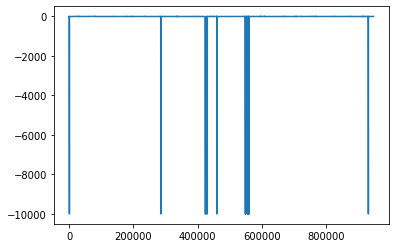

In [7]:
plt.plot(station["rain1"])

In [8]:
station = station[selection]
station2 = station2[selection2]

In [9]:
station, stats = threshold_filter(station, "T", threshold = (-30,50))
station, stats = threshold_filter(station, "rh", threshold = (0,100))
station, stats = threshold_filter(station, "SM0", threshold = (-1,100))
station, stats = threshold_filter(station, "rain1", threshold = (-2000,1000))

In [10]:
station = time_sum(station, sum_minutes= 3)

/home/stein/nextcloud/PHD/transform_code/tools.py:203: RuntimeWarning: Mean of empty slice
  data = np.nanmean(new[:,:,1:].astype("float64"),axis=1)


In [11]:
station2["dateTime"] = pd.to_datetime(station2["dateTime"]) - pd.Timedelta(minutes=30)

In [12]:
station2.rename(columns={"dateTime": "datetime", "T_air": "T"}, inplace=True)

In [13]:
station = pd.concat([station, station2])

In [15]:
station.reset_index(drop=True, inplace=True)

In [17]:
station.to_csv("/home/datasets4/stein/station_processed/extreme_station.csv", index=False)

# Only air temperature

In [2]:
# for temperature I summed 30 minutes to the first timestamp of the first 30 minutes.     17.30 --> 17.30-17.59
# same for weather station: 17.00 --> 17:00 - 17.10 + 17.20,  17.30 --> 17.30/40/50

In [36]:
base = pd.read_csv("../30_min_final/block_2_soil_temp_30_min_no_filling.csv")
time = pickle.load(open("../data_transform/restructured_raw/" + "timeLine" + ".p", "rb"))

In [37]:
start = base["datetime"].astype('datetime64[D]').values[0]
end = pd.Timestamp("2021-01-05 17:59:00")

In [38]:
station = pickle.load(open("../data_transform/weatherstation.p" , "rb"))

In [39]:
station.rename(columns={"Date Time": "datetime","T (degC)": "temp"},inplace=True)
station = station.loc[:,["datetime", "temp"]]
station = station[(station["datetime"].values >= start) & (station["datetime"].values <= end)] # last

In [40]:
outliers = threshold_filter(station)
station.loc[outliers,"temp"] = math.nan

In [41]:
a = np.nanmean(station["temp"].values.reshape(-1,3),axis=1)
b = station["datetime"].values.reshape(-1,3)[:,0]
station = pd.DataFrame(b,columns=["datetime"])
station["temp"] = a

/home/stein/envs/idiv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [10]:
station.to_csv("../30_min_final/station_temperature_30min_no_filling.csv", index=False)

In [11]:
mean,leap = get_season_means_30(station)
leapYear = pd.concat([mean[((mean["datetime"] < '2003-3-01'))],leap,mean[((mean["datetime"] >= '2003-3-01'))]])
cycle = pd.concat([mean,leapYear,mean, mean])
fullTimeLine = pd.concat([cycle,cycle,cycle,cycle,mean,leapYear[:-2460]])
station["filling"] = fullTimeLine.Mean.values

In [12]:
#save filled indices
filled = station.loc[np.isnan(station["temp"]), "temp"].index.values

In [13]:
station.loc[np.isnan(station["temp"]), "temp"] =  station.loc[np.isnan(station["temp"]), "filling"].values

In [128]:
station[["datetime", "temp"]].to_csv("../30_min_final/station_temperature_30min.csv", index=False)

In [129]:
info = pd.DataFrame(filled, columns=["indices in data table"])
info["datetime"] = station.loc[filled]["datetime"].values
info["original value"] = np.nan
info["filling type"] = "season mean"

In [130]:
info.to_csv("../30_min_final/station_temperature_30min_processing_info.csv", index=False)

# Everything that has no large gaps and is weather

In [120]:
# choose here with or without filling
base = pd.read_csv("../30_min_final/block_2_soil_temp_30_min_no_filling.csv")
time = pickle.load(open("../data_transform/restructured_raw/" + "timeLine" + ".p", "rb"))

In [121]:
start = base["datetime"].astype('datetime64[D]').values[0]
end = pd.Timestamp("2021-01-05 17:59:00")

In [122]:
station = pickle.load(open("../data_transform/weatherstation.p" , "rb"))
station.rename(columns={"Date Time": "datetime"},inplace=True)
station = station[(station["datetime"].values >= start) & (station["datetime"].values <= end)] # last

In [123]:
kickOut = []
for x in station.columns:
    if "ST" in x or "SH" in x or "SM" in x: 
        kickOut.append(x)
kickOut2 = ['dsh (g/kg)', 'dt (K)', 'Cal (cnt)', 'Tlog (degC)','Heating1 (%)', 'Heating2 (%)']
# double measurements: 
kickOut3 = ['T1 (degC)', 'T2 (degC)', 'rh1 (%)', 'rh2 (%)','sh1 (g/kg)','sh2 (g/kg)']

In [124]:
station = station.drop(columns=kickOut)
station = station.drop(columns=kickOut2)
station = station.drop(columns=kickOut3)

In [127]:
for x in station.columns[1:]: 
    outliers= threshold_filter_2(station[["datetime", x]], threshold=(-2000,999999999999))
    station.loc[outliers,x] = math.nan

In [128]:
means = {}
variables = station.columns[1:]
for x in variables: 
    means[x] = np.nanmean(station[x].values.reshape(-1,3),axis=1)  
time = station["datetime"].values.reshape(-1,3)[:,0]
station = pd.DataFrame(time,columns=["datetime"])
for x in variables: 
    station[x] = means[x]

/home/stein/envs/idiv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [139]:
kickOut4  = []
# drop with a lot of misssing: 
for x in station.columns[1:]:
    if station[x].isnull().sum()> 100000:
        kickOut4.append(x)
station = station.drop(columns=kickOut4)

In [141]:
station.iloc[18:].to_csv("../30_min_final/station_all_data.csv", index=False)

# Variables for filling

In [172]:
# choose here with or without filling
base = pd.read_csv("../30_min_final/block_2_soil_temp_30_min_no_filling.csv")
time = pickle.load(open("../data_transform/restructured_raw/" + "timeLine" + ".p", "rb"))

In [173]:
start = base["datetime"].astype('datetime64[D]').values[0]
end = pd.Timestamp("2021-01-05 17:59:00")

In [174]:
station = pickle.load(open("../data_transform/weatherstation.p" , "rb"))
station.rename(columns={"Date Time": "datetime","T (degC)": "temp", 'ST004 (degC)': "ST04", 'ST016 (degC)': "ST16"},inplace=True)
station = station.loc[:,["datetime", 'ST04','ST16',"temp" ]]
station = station[(station["datetime"].values >= start) & (station["datetime"].values <= end)] # last

In [175]:
for x in station.columns[1:]: 
    outliers= threshold_filter_2(station[["datetime", x]], threshold=(-2000,999999999999))
    station.loc[outliers,x] = math.nan

Text(0.5, 1.0, 'ST16')

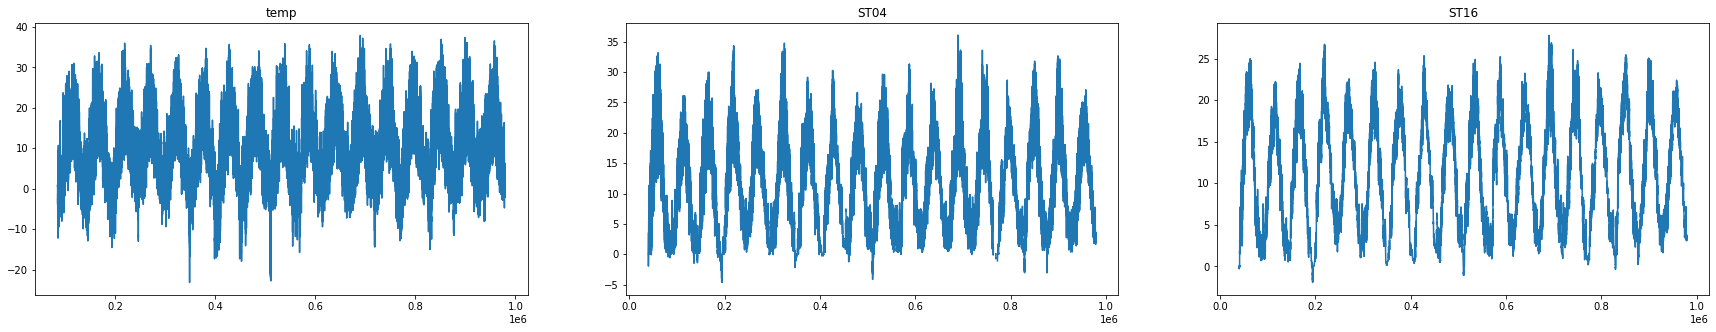

In [176]:
fig, axs = plt.subplots(1, 3,figsize=(30,5))
axs[0].plot(station["temp"])
axs[0].set_title("temp")
axs[1].plot(station['ST04'])
axs[1].set_title('ST04')
axs[2].plot(station['ST16'])
axs[2].set_title('ST16')

In [177]:
a = np.nanmean(station["temp"].values.reshape(-1,3),axis=1)
b = np.nanmean(station["ST04"].values.reshape(-1,3),axis=1)
c = np.nanmean(station["ST16"].values.reshape(-1,3),axis=1)
d = station["datetime"].values.reshape(-1,3)[:,0]
station = pd.DataFrame(d,columns=["datetime"])
station["temp"] = a
station["ST04"] = b
station["ST16"] = c

/home/stein/envs/idiv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/stein/envs/idiv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/stein/envs/idiv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [178]:
station.iloc[18:].to_csv("../30_min_final/station_data_fill_base_no_filling.csv", index=False)  
#cut away the early dates because target

In [179]:
variables = ["temp", "ST04", "ST16"]

In [180]:
for x in variables: 
    mean,leap = get_season_means_30(station[["datetime", x]])
    leapYear = pd.concat([mean[((mean["datetime"] < '2003-3-01'))],leap,mean[((mean["datetime"] >= '2003-3-01'))]])
    cycle = pd.concat([mean,leapYear,mean, mean])
    fullTimeLine = pd.concat([cycle,cycle,cycle,cycle,mean,leapYear[:-2460]])
    station["filling_" + x] = fullTimeLine.Mean.values

In [181]:
filled = {}
for x in variables:
    filled[x] = station.loc[np.isnan(station[x]), x].index.values

In [182]:
for x in variables: 
    station.loc[np.isnan(station[x]), x] =  station.loc[np.isnan(station[x]), "filling_" + x].values

In [183]:
station.loc[18:, ["datetime"] + variables].to_csv("../30_min_final/station_data_fill_base.csv", index=False)

In [185]:
pickle.dump(filled,open("../30_min_final/station_data_fill_base_fillings.p", "wb"))

# 5 most representable variables

- temp 
- air preassure
- rain1 
- wind velocity
- relative humidity 
- Photosyntetically active radiation

In [154]:
variables = ["temp","p (mbar)",'wv (m/s)','rh (%)','PAR (umol/sm**2)','rain1 (mm)' ]

In [155]:
base = pd.read_csv("../30_min_final/block_2_soil_temp_30_min_no_filling.csv")

In [156]:
time = pickle.load(open("../data_transform/restructured_raw/" + "timeLine" + ".p", "rb"))

In [157]:
start = base["datetime"].astype('datetime64[D]').values[0]
end = pd.Timestamp("2021-01-05 17:59:00")

In [158]:
station = pickle.load(open("../data_transform/weatherstation.p" , "rb"))
station.rename(columns={"Date Time": "datetime","T (degC)": "temp"},inplace=True)

In [159]:
station = station[(station["datetime"].values >= start) & (station["datetime"].values <= end)] # last

In [160]:
for x in variables: 
    outliers= threshold_filter_2(station[["datetime", x]], threshold=(-2000,999999999999))
    station.loc[outliers,x] = math.nan

In [142]:
sum(station[["datetime"] + variables].isnull().values)

array([0, 0, 0, 0])

Text(0.5, 0, 'time')

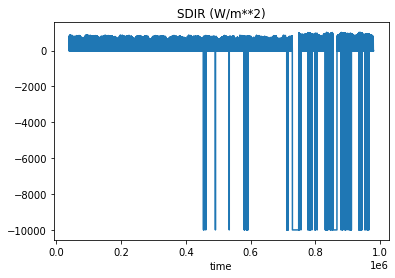

In [161]:
# problematic
plt.plot(station['SDIR (W/m**2)'])
plt.title('SDIR (W/m**2)')
plt.xlabel("time")

Text(0.5, 1.0, 'PAR (umol/sm**2)')

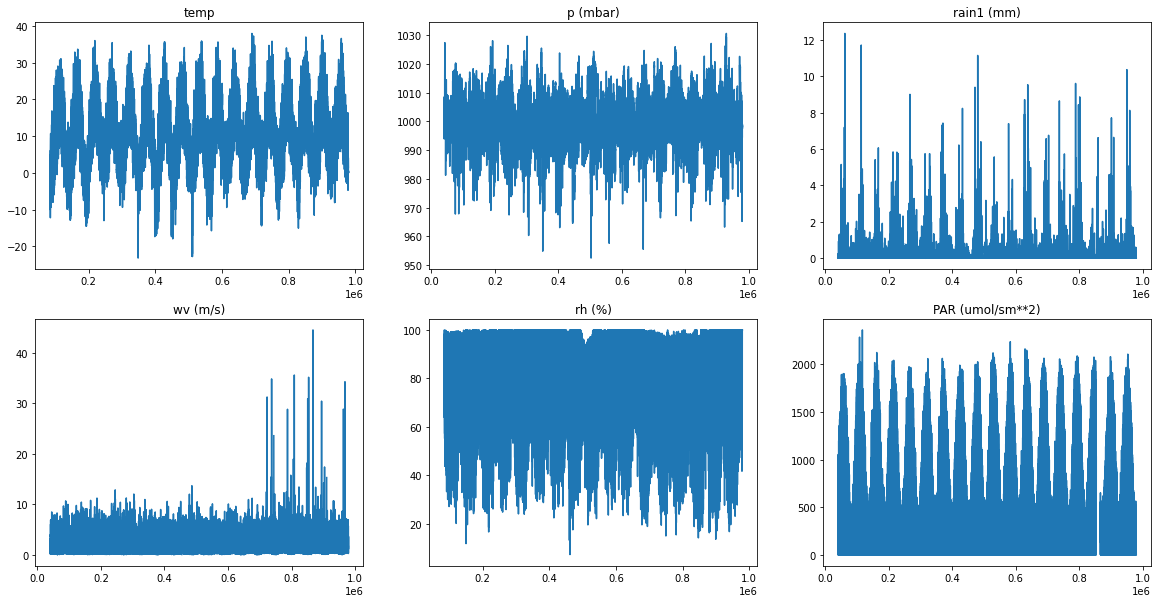

In [162]:
fig, axs = plt.subplots(2, 3,figsize=(20,10))

axs[0,0].plot(station["temp"])
axs[0,0].set_title("temp")
axs[0,1].plot(station["p (mbar)"])
axs[0,1].set_title("p (mbar)")
axs[0,2].plot(station['rain1 (mm)'])
axs[0,2].set_title('rain1 (mm)')
axs[1,0].plot(station['wv (m/s)'])
axs[1,0].set_title('wv (m/s)')
axs[1,1].plot(station['rh (%)'])
axs[1,1].set_title('rh (%)')
axs[1,2].plot(station['PAR (umol/sm**2)'])
axs[1,2].set_title('PAR (umol/sm**2)')

In [163]:
means = {}
for x in variables: 
    means[x] = np.nanmean(station[x].values.reshape(-1,3),axis=1)  
time = station["datetime"].values.reshape(-1,3)[:,0]
station = pd.DataFrame(time,columns=["datetime"])
for x in variables: 
    station[x] = means[x]

/home/stein/envs/idiv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [164]:
for x in variables: 
    mean,leap = get_season_means_30(station[["datetime", x]])
    leapYear = pd.concat([mean[((mean["datetime"] < '2003-3-01'))],leap,mean[((mean["datetime"] >= '2003-3-01'))]])
    cycle = pd.concat([mean,leapYear,mean, mean])
    fullTimeLine = pd.concat([cycle,cycle,cycle,cycle,mean,leapYear[:-2460]])
    station["filling_" + x] = fullTimeLine.Mean.values

In [165]:
filled = {}
for x in variables:
    filled[x] = station.loc[np.isnan(station[x]), x].index.values

In [166]:
for x in variables: 
    station.loc[np.isnan(station[x]), x] =  station.loc[np.isnan(station[x]), "filling_" + x].values

Text(0.5, 1.0, 'PAR (umol/sm**2)')

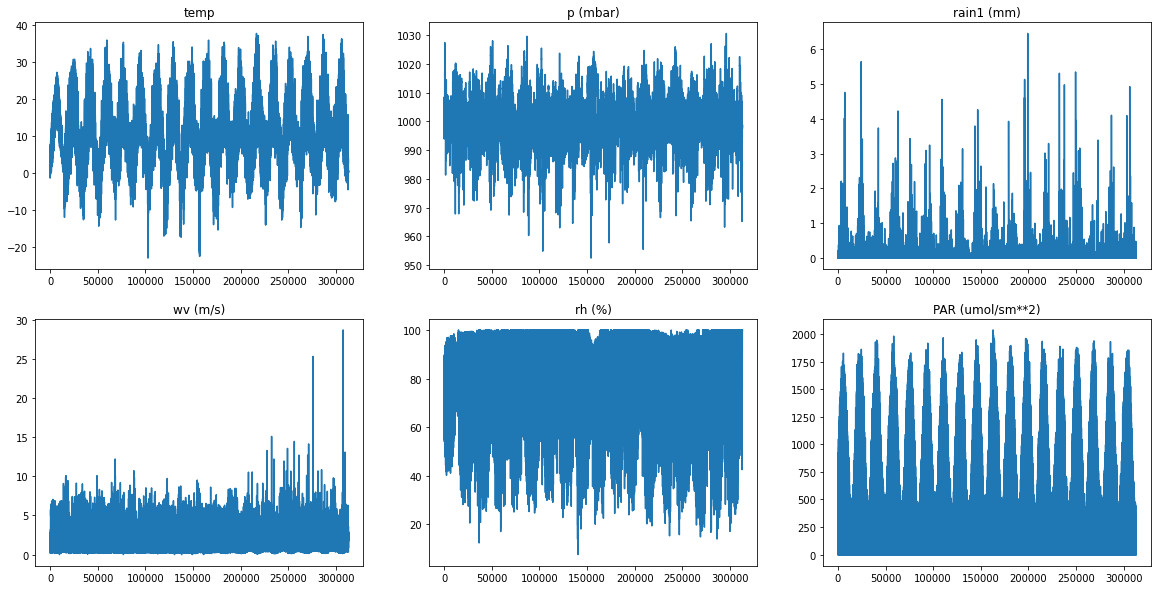

In [167]:
fig, axs = plt.subplots(2, 3,figsize=(20,10))

axs[0,0].plot(station["temp"])
axs[0,0].set_title("temp")
axs[0,1].plot(station["p (mbar)"])
axs[0,1].set_title("p (mbar)")
axs[0,2].plot(station['rain1 (mm)'])
axs[0,2].set_title('rain1 (mm)')
axs[1,0].plot(station['wv (m/s)'])
axs[1,0].set_title('wv (m/s)')
axs[1,1].plot(station['rh (%)'])
axs[1,1].set_title('rh (%)')
axs[1,2].plot(station['PAR (umol/sm**2)'])
axs[1,2].set_title('PAR (umol/sm**2)')

In [168]:
station[["datetime"] + variables].to_csv("../30_min_final/station_5_30min.csv", index=False)

In [169]:
pickle.dump(filled,open("../30_min_final/station_5_fillings.p", "wb"))